In this notebook, I'm going to simulate future city budgets, using the 2024 budget as a baseline. 
This work only looks at the General Fund, because it is where the structural deficit in the operating budget lives. 
Look in the README file to find the blog post that goes into this in greater detail.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
pd.options.display.float_format = '{:.2f}'.format


The data I'm using is in the AgencyBudgets spreadsheet, which has both revenue and expenditures. (The expenditures are the AgencyBudget sheets) This is a spreadhseet I created by copying data out of the city's budget PDFs and saving the set of numbers into a more concise format. There are a couple of sheets, the relevant ones are the Adjusted sheets.

For the AgencyBudgetsAdjusted sheet, I took out some of the one-time funds - the Clerk had a one-time grant to buy election equipment that the stupid WI Consitutional Amendment outlawed.
For expenditures, my spreadsheet uses the city agency budget PDFs to find the salaries, insurance and benefits, supplies, and purchased services for each agency.
However, for some agencies there are non-general-fund things in their budgets but it's not always clear what is and isn't counted against the general fund for staff. 
For a simplifying approach, I took the amount of general vs non-general fund overall budget, and then used that ratio to scale the number of staff and the expenditures on salaries, benefits, etc. 
In the original spreadsheet, you'll see these as 'Scaled' columns, e.g. 'ScaledSalary' is the agency salary budget scaled by what I think is the portion of the salaries funded by the general fund. 


On the revenue side I took out the COVID funds, the TIF closure funds, and the reserve fund usage, so the RevenueAdjusted figure starts out with $18M less than the actual 2024 revenue. 

In [2]:
expenditures_base = pd.read_excel('AgencyBudgets.xlsx', sheet_name='AgencyBudgetsAdjusted', engine='openpyxl')
revenues_base = pd.read_excel('AgencyBudgets.xlsx', sheet_name='RevenueAdjusted', engine='openpyxl')

I'm also mostly ignoring debt service.
Because it's exempt from the levy limit, any debt we add on the expenditure side shows up on the revenue side automatically. 
This means that my cost-to-continue numbers are less than the city's presentations and my revenue numbers are also lower, but my structural gap number is about the same. 
There is also some nuance in how debt service can "generate" some additional capacity in the levy, but I'm ignoring that in my simulation, so my revenue numbers are likely lower than what the City Finance department would model in their projections. 

In the simulations farther down, we'll take the baseline 2024 budget, both revenue and expenditures, and grow them by some percentages each year to compute a budget for that year. 
We'll do that in a loop, computing a new budget for each year.

Before we start with those loops we net to set up some baseline budgets. 

First, we'll set up the revenue baseline - we don't do much other than copy over data from the spreadsheet, so this "setup" is mostly just to fix an Excel-to-Python weirdness but we'll do the tweak of the debt service number here instead of in Excel to make the Excel version a bit easier to follow. 

In [3]:
def create_baseline_revenue(df):
    # Create a copy of the dataframe
    df_copy = df.copy()

    # Set 'Source' as the index
    df_copy.set_index('Source', inplace=True)

    # we are leaving debt service out of the revenue baseline
    df_copy.loc['PropertyTaxDebt', 'Amount'] -= 63879900
    
    #convert Amount to float
    df_copy['Amount'] = df_copy['Amount'].astype('float64')
    return df_copy

Similarly for expenditures we are mostly just copying data over from the spreadsheet and fixing an Excel-to-Python quirk. To keep this Python code readable, I toss out the non-scaled versions of those columns because I don't use them and rename the scaled versions to be what I really care about.

In [4]:

def create_baseline_expenditures(expenditures_df):
    # Create a copy of the dataframe
    df_copy = expenditures_df.copy()

    # Select the required columns
    df_copy = df_copy[['agencyname', 'GenFundTotal', 'ScaledSalary', 'ScaledHealthInsurance', 'ScaledOtherBenefits', 'ScaledSupplies', 'ScaledPurchasedServices', 'ScaledStaff']]

    # Rename the columns
    df_copy.columns = df_copy.columns.map(lambda x: x.replace('Scaled', '') if 'Scaled' in x else x)

    df_copy['GenFundTotal'] = df_copy['GenFundTotal'].astype('float64')

    # Set 'agencyname' as the index
    df_copy.set_index('agencyname', inplace=True)

    # Ignore the remaining budget for now. This is mostly the interdepartrment charges and I think we can just pretend it all comes out in the wash for now
    # Create 'RemainingBudget' column
    #df_copy['RemainingBudget'] = df_copy['GenFundTotal'] - df_copy[['Salary', 'HealthInsurance', 'OtherBenefits', 'Supplies', 'PurchasedServices']].sum(axis=1)

    # Set 'RemainingBudget' to 0 for 'Public_Health' and 'Metro_Transit'
    #df_copy.loc[['Public_Health', 'Metro_Transit'], 'RemainingBudget'] = 0

    return df_copy

Now we'll write some code to actually compute new revenue and expenditures.
It needs last year's revenue or expenditures to compute it - hence why we created 'baseline' versions in the earlier code. 
You can compare these to the City's revenue summary PDF here: https://www.cityofmadison.com/finance/documents/budget/2024/operating/adopted/FundingSource.pdf

These are (mostly) the figures the city finance department uses as its revenue assumptions.
I handle the interest rate calcuation slightly different than how the City models it. 
The City models the investement interest as part of the 'Ungrouped Revenue' - interest, encroachment revenue (the money the City makes from businesses that have awnings "encroach" or hang over the sidewalk) and just grows the whole thing by 2% a year.
I am breaking out interest and assuming that the city will grow its overall investment pool by about 2% a year and so we'll calculate interest on that. 
I am doing this so I can model different interest rates later in a full monte-carlo simulation. 

In [5]:
default_net_new_construction = 0.02
default_cpi = 0.022
default_state_increase = 0.02
default_reserves = 300_000_000.0
default_interest_rate = 0.02
default_roomtax = 0.05

In [6]:

def update_annual_revenues(df, net_new_construction, cpi, state_increase, reserves, interest_rate, roomtax, year):
    # Create a copy of the dataframe
    df_copy = df.copy()

    # Create 'PrevAmount' column
    df_copy['PrevAmount'] = df_copy['Amount'].copy()

    # Update 'Amount' for 'PropertyTaxBase' and 'RoomTax'
    df_copy.loc['PropertyTaxBase', 'Amount'] *= (1 + net_new_construction)
    df_copy.loc['RoomTax', 'Amount'] *= (1 + roomtax)

    # Update 'Amount' for 'Fines', 'OtherTaxes', 'OtherPaymentsTransfers', 'LicenseAndPermits', and 'ChargeForServices'
    for source in ['Fines', 'OtherTaxes', 'OtherPaymentsTransfers', 'OtherUngroupedRev', 'LicensesAndPermits', 'ChargeForServices']:
        df_copy.loc[source, 'Amount'] *= (1 + cpi)

    # Update 'Amount' for state sources
    for source in ['StMuniAid', 'StUtilityAid', 'StVideoServiceProvider', 'StateExpenditureRestraint', 'StPaymentForMuniServices', 'StGenTransportationAid', 'StConnectingHighwayAid', 'StRecyclingAid', 'StExemptComputerReimb', 'StatePersonalPropertyExemnt', 'FireInsuranceDuesPmt']:
        df_copy.loc[source, 'Amount'] *= (1 + state_increase)


    reserves_growth_rate = 0.02  # 2% growth rate
    years_since_2024 = year - 2024
    temp = (1.0 + reserves_growth_rate) ** years_since_2024
    new_reserves = default_reserves * temp
    # Replace 'Amount' for 'InterestOnInvestments'
    df_copy.loc['InterestOnInvestments', 'Amount'] = new_reserves * interest_rate

    return df_copy

Similarly, let's create a new year of expenditures. 
There is a bit of strange approach here because I haven't gone back and cleaned it up, but the first thing we need to do is figure out what was the average salary in each department (and average health insurance, etc). 
Once we know the average salary and benefits amounts, we'll update them for the next year by that year's COLA and the health insurance increase rate. 

The next thing we need to do is add more staff to the City. 
In reality this would be focused by policy - should we add more police or more librarians? 
Because City Finance staff can't really model policy, they just assume 20 more staff across the city, so we do something similar. 
For each department we figure out what percentage of overall city staff are part of this department, and then we add some portion of the new staff to that department. This of course is absurd but the math roughly works out. 
(Mostly. There are places where it wouldn't - for example, the amount the city pays to the Wisconsin Retirement System for each firefigher and cop are much higher than what it pays for other General Municipal Employee (gme) because cops and firefighters can retire earlier.)

For the agencies where the city just kicks in money - Metro, Public Health, the 'Misc' allocations that are mostly for a citywide extended leave program - just grow that at 4% a year. 

In [7]:


def simulate_year(df, police_cola, gme_cola, health_ins_rate, new_staff_count, subsidy_increase, cpi_rate):
    # Create a copy of the dataframe, we're gonna update things in-place
    df_copy = df.copy()

    df_copy[['PrevGenFundTotal', 'PrevSalary', 'PrevHealthInsurance', 'PrevOtherBenefits', 'PrevPurchasedServices', 'PrevSupplies', 'PrevStaff']] = df_copy[['GenFundTotal', 'Salary', 'HealthInsurance', 'OtherBenefits', 'PurchasedServices', 'Supplies', 'Staff']].copy()
    # Create temporary columns
    df_copy['AverageSalary'] = df_copy['Salary'] / df_copy['Staff'].replace(0, 1)
    df_copy['AverageHealthInsurance'] = df_copy['HealthInsurance'] / df_copy['Staff'].replace(0, 1)
    df_copy['AverageOtherBenefits'] = df_copy['OtherBenefits'] / df_copy['Staff'].replace(0, 1)

    # Calculate total staff and create PercentStaff column
    total_staff = df_copy['Staff'].sum()
    df_copy['PercentStaff'] = df_copy['Staff'] / total_staff

    # Update AverageSalary and AverageOtherBenefits. Assume that the non-health insurance benefits increase at the same rate as the salary (FICA, etc)
    df_copy.loc[df_copy.index != 'Police', ['AverageSalary', 'AverageOtherBenefits']] *= (1 + gme_cola)
    df_copy.loc[df_copy.index == 'Police', ['AverageSalary', 'AverageOtherBenefits']] *= (1 + police_cola)

    # Update AverageHealthInsurance. This unforunately goes faster than the salary
    df_copy['AverageHealthInsurance'] *= (1 + health_ins_rate)

    # Update the number of staff. This is weird because we're spreading the 20 staff really fractionally across the entire city
    # but for now I'm going to roll with it. 
    # This makes a mess of WRS - cops and firefighter WRS rates a higher than other GMEs because cops/fighers can retire earlier
    df_copy['Staff'] += new_staff_count * df_copy['PercentStaff']

    # so early on I was going to use the average salary to do a bunch of other stuff but then I decided not to bother
    # but so this was kind of a convuluted way to get the update the salaries etc
     
    # Create NewSalary, NewHealthInsurance, and NewOtherBenefits columns
    df_copy['NewSalary'] = df_copy['AverageSalary'] * df_copy['Staff']
    df_copy['NewHealthInsurance'] = df_copy['AverageHealthInsurance'] * df_copy['Staff']
    df_copy['NewOtherBenefits'] = df_copy['AverageOtherBenefits'] * df_copy['Staff']

    # Update Supplies and PurchasedServices. This goes at the CPI rate
    df_copy['NewSupplies'] = df_copy['Supplies'] * (1 + cpi_rate)
    df_copy['NewPurchasedServices'] = df_copy['PurchasedServices'] * (1 + cpi_rate)

    # Update GenFundTotal - no salaries on the subsisiary "agencies"
    agencies_to_update = df_copy.index.difference(['Metro_Transit', 'Public_Health', 'Direct_Appropriation'])
    df_copy.loc[agencies_to_update, 'GenFundTotal'] += (df_copy.loc[agencies_to_update, ['NewSalary', 'NewHealthInsurance', 'NewOtherBenefits', 'NewSupplies', 'NewPurchasedServices']].sum(axis=1) - df_copy.loc[agencies_to_update, ['Salary', 'HealthInsurance', 'OtherBenefits', 'Supplies', 'PurchasedServices']].sum(axis=1))

    # Replace the original Salary, HealthInsurance, OtherBenefits, Supplies, and PurchasedServices columns with the New versions of them
    df_copy['Salary'] = df_copy['NewSalary']
    df_copy['HealthInsurance'] = df_copy['NewHealthInsurance']
    df_copy['OtherBenefits'] = df_copy['NewOtherBenefits']
    df_copy['Supplies'] = df_copy['NewSupplies']
    df_copy['PurchasedServices'] = df_copy['NewPurchasedServices']

    # assume a 4% increase to the metro and MDCPH subsidies. Also just use 4% for the misc things? It's only 10M so we can be off by a bit but it's figuring out a better number to use here
    df_copy.loc['Metro_Transit', 'GenFundTotal'] *= (1 + subsidy_increase)
    df_copy.loc['Public_Health', 'GenFundTotal'] *= (1 + subsidy_increase)
    df_copy.loc['Direct_Appropriation', 'GenFundTotal'] *= (1 + subsidy_increase) 
       
    # Drop temporary columns
    df_copy.drop(['AverageSalary', 'AverageHealthInsurance', 'AverageOtherBenefits', 'PercentStaff', 'NewSalary', 'NewHealthInsurance', 'NewOtherBenefits', 'NewSupplies', 'NewPurchasedServices'], axis=1, inplace=True)

    return df_copy


Next we'll just do some spot checks.

In [8]:
fy2024_expenditures = create_baseline_expenditures(expenditures_base)
fy2024_revenue = create_baseline_revenue(revenues_base)

In [9]:
fy2025_revenue = update_annual_revenues(fy2024_revenue, net_new_construction=0.022, cpi=0.02, state_increase=0.02, reserves=300_000_000, interest_rate=0.02, roomtax= 0.05, year=2025)
fy2025_expenditures = simulate_year(fy2024_expenditures, police_cola = 0.03, gme_cola=0.03, health_ins_rate = 0.065, new_staff_count=20, subsidy_increase=0.04, cpi_rate=0.022)

Let's start by doing a spot check to make sure things match. 
Recall earlier that I to try to keep things simple, I took out debt service from both the expenditures and revenue for 2024. 
I also ahead-of-time took out the 18M in one-time funds in the 2024 revenue amount. 
If we add them back in we get the same amount that should match the 2024 budget. (there's a rounding error somewhere, don't worry about the dollar)

In [10]:
fy2024_expenditures['GenFundTotal'].sum() + 63879900

405368749.0

In [11]:
fy2024_revenue['Amount'].sum()  + 63_879_900 + 17_900_000

405368750.0

In [12]:
fy2024_budget_gap = fy2024_expenditures['GenFundTotal'].sum() - fy2024_revenue['Amount'].sum()  
fy2024_budget_gap

17899999.0

The City projects expenditures will be $22M higher in 2025 than in 2024. 
That includes $6.5M in debt service that again we're not counting in these simulations, so we're looking for a $15.5M increase in the overall expenditures. 
For now I'm off by about $2M in expenditures, or "cost to continue". 

In [13]:
fy2025_cost_to_continue = fy2025_expenditures['GenFundTotal'].sum() - fy2024_expenditures['GenFundTotal'].sum() 
fy2025_cost_to_continue

13581256.803922117

For revenue, the City is projecting an increase of $13M in 2025. $10.5M of that is in the levy limit, but that includes $6.5M to match the $6.5M in debt service, so we will exclude that. 
So we are looking at an fy2025_revenue_increase of $6.5M.
My revenue model comes up a bit short for now, at pretty close to $6M

In [14]:
fy2025_revenue_increase = fy2025_revenue['Amount'].sum() - fy2024_revenue['Amount'].sum()
fy2025_revenue_increase

5953722.136000097

So, our 2025 budget gap is previous_budget_gap + (fy2025_cost_to_continue - fy2025_revenue_increase).
In a perfect world this would be $27M but my model is both underspending and under revenue-ing.

In [15]:
fy2025_budget_gap = fy2024_budget_gap + fy2025_cost_to_continue - fy2025_revenue_increase
fy2025_budget_gap

25527533.66792202

So, not perfect, but I think acceptable for what we're doing today.

Let's go ahead and project forward some number of years. 
To make it a bit easier, we are going to pass in the parameters as one big slug.
Let's write a function to generate the parameters, because later on we'll create a version that generates different scenarios - we'll model recessions etc. 

For now though, we're going to use the defaults and create one scenario.


In [16]:
# hack for now, eventually we'll use this to create monte carlo simulations
def create_parameters(years):
    for year in years:
        revenue_parameters = {
            'net_new_construction': default_net_new_construction,
            'cpi': default_cpi,
            'state_increase': default_interest_rate,
            'reserves': default_reserves,
            'interest_rate': default_interest_rate,
            'roomtax': default_roomtax
        }

        expenditure_parameters = {
            'police_cola': 0.03,
            'gme_cola': 0.03,
            'health_ins_rate': 0.065,
            'new_staff_count': 20,
            'subsidy_increase': 0.04,
            'cpi_rate': 0.022
        }

        yield revenue_parameters, expenditure_parameters

This is the core of the simulation. 
We create a baseline, setup a baseline budget gap, and then run a loop for every year between 2025 and 2059 and simulate that year, using the previous year's result.  
We save each year's results and some important metrics about the year to a DataFrame and move on to the next year.

In [34]:
def simulation_trial(create_parameters_func=create_parameters):
    # Initialize current_year_revenue and current_year_expenditure
    current_year_revenue = create_baseline_revenue(revenues_base)
    current_year_expenditure = create_baseline_expenditures(expenditures_base)

    # Initialize an empty dataframe
    simulation_df = pd.DataFrame()

    # Initialize previous_year_gap
    previous_year_gap = 17_900_000

    # Get parameters for each year
    for year, (revenue_parameters, expenditure_parameters) in enumerate(create_parameters_func(range(2025, 2060)), start=2025):
        # Update annual revenues
        current_year_revenue = update_annual_revenues(current_year_revenue, **revenue_parameters, year=year)

        # Simulate year
        current_year_expenditure = simulate_year(current_year_expenditure, **expenditure_parameters)

        # Calculate metrics
        expenditures = current_year_expenditure['GenFundTotal'].sum()
        revenue = current_year_revenue['Amount'].sum()
        cost_to_continue = expenditures - current_year_expenditure['PrevGenFundTotal'].sum()
        revenue_increase = revenue - current_year_revenue['PrevAmount'].sum()
        incremental_gap = cost_to_continue - revenue_increase
        running_budget_gap = previous_year_gap + incremental_gap
        gap_percentage = running_budget_gap / expenditures

        health_insurance = current_year_expenditure['HealthInsurance'].sum()
        health_insurance_delta = health_insurance - current_year_expenditure['PrevHealthInsurance'].sum()

        # Append to dataframe
        new_row = pd.DataFrame({
            'Year': [year],
            'Expenditures': [expenditures],
            'Revenue': [revenue],
            'CostToContinue': [cost_to_continue],
            'RevenueIncrease': [revenue_increase],
            'RunningBudgetGap': [running_budget_gap],
            'GapAsPercentageOfExpenditures': [gap_percentage], 
            'IncrementalGap': [incremental_gap],
            'HealthInsurance': [health_insurance],
            'HealthInsuranceDelta': [health_insurance_delta],
        })
        simulation_df = pd.concat([simulation_df, new_row], ignore_index=True)
        # Add GenFundTotal for each agency as a new column
        for agency, gen_fund_total in current_year_expenditure['GenFundTotal'].items():
            simulation_df.loc[simulation_df['Year'] == year, agency] = gen_fund_total

        # Update previous_year_gap
        previous_year_gap = running_budget_gap

    # Set 'Year' as the index
    simulation_df.set_index('Year', inplace=True)
    # create a health_insurance_portion_of_expenditures column
    simulation_df['HealthInsuranceOverallPortion'] = simulation_df['HealthInsurance'] / simulation_df['Expenditures']
    #create a health_insurance_cost_to_continue_portion column  
    simulation_df['HealthInsuranceCostToContinuePortion'] = simulation_df['HealthInsuranceDelta'] / simulation_df['CostToContinue']
    # rearraange columns so HealthInsuranceCostToContinuePortion and HealthInsuranceOverallPortion are after the HealthInsuanrceDelta column
    simulation_df = simulation_df[['Expenditures', 'Revenue', 'CostToContinue', 'RevenueIncrease', 'IncrementalGap', 'RunningBudgetGap', 'GapAsPercentageOfExpenditures', 'HealthInsurance', 'HealthInsuranceDelta', 'HealthInsuranceCostToContinuePortion', 'HealthInsuranceOverallPortion'] + list(current_year_expenditure.index)]
    return simulation_df

In [35]:
sim_results = simulation_trial()
sim_results

,Expenditures,Revenue,CostToContinue,RevenueIncrease,IncrementalGap,RunningBudgetGap,GapAsPercentageOfExpenditures,HealthInsurance,HealthInsuranceDelta,HealthInsuranceCostToContinuePortion,...,Office_of_the_Independent_Monitor,Police_Department,Public_Health,Engineering_Division,Parks_Division,Streets_Division,Metro_Transit,Traffic_Engineering,Transportation_Department,Direct_Appropriation
Year,,,,,,,,,,,,,,,,,,,,,
2025,355070105.80,329288152.93,13581256.80,5699302.93,7881953.87,25781953.87,0.07,27901251.94,1953769.36,0.14,...,527612.30,94627875.81,10729567.68,6036825.58,17344145.65,28615826.65,16354000.00,10213680.22,629470.29,10479472.64
2026,369218221.95,335112857.30,14148116.15,5824704.37,8323411.78,34105365.66,0.09,29999383.20,2098131.26,0.15,...,546473.22,98376406.54,11158750.39,6151534.77,18102781.98,29706416.63,17008160.00,10647275.16,653897.78,10898651.55
2027,383958809.32,341065988.97,14740587.37,5953131.67,8787455.69,42892821.35,0.11,32252388.74,2253005.54,0.15,...,566029.12,102286014.87,11605100.40,6271194.47,18893767.65,30840961.08,17688486.40,11098417.29,679376.31,11334597.61
2028,399318769.50,347150659.06,15359960.18,6084670.09,9275290.09,52168111.44,0.13,34671537.60,2419148.86,0.16,...,586307.52,106364131.17,12069304.42,6396039.39,19718625.62,32021390.48,18396025.86,11567899.66,705954.04,11787981.51
2029,415326366.41,353370066.84,16007596.91,6219407.78,9788189.13,61956300.56,0.15,37268909.47,2597371.87,0.16,...,607337.18,110618567.10,12552076.60,6526316.75,20578959.62,33249730.57,19131866.89,12056556.11,733681.58,12259500.77
2030,432011303.38,359727502.78,16684936.97,6357435.94,10327501.03,72283801.60,0.17,40057452.44,2788542.97,0.17,...,629148.08,115057537.42,13054159.66,6662287.01,21476458.96,34528107.74,19897141.57,12565263.64,762612.12,12749880.80
2031,449404804.98,366226351.69,17393501.60,6498848.91,10894652.69,83178454.29,0.19,43051044.86,2993592.41,0.17,...,651771.59,119689683.21,13576326.05,6804224.64,22412903.58,35858754.61,20693027.23,13094944.94,792801.59,13259876.04
2032,467539703.94,372870096.04,18134898.96,6643744.34,11491154.61,94669608.90,0.20,46264561.55,3213516.69,0.18,...,675240.46,124524096.52,14119379.09,6952418.99,23390169.47,37244016.07,21520748.32,13646571.01,824308.80,13790271.08
2033,486450533.42,379662319.33,18910829.48,6792223.30,12118606.19,106788215.08,0.22,49713944.74,3449383.20,0.18,...,699588.91,129570346.61,14684154.25,7107175.16,24410234.41,38686355.58,22381578.25,14221164.07,857195.61,14341881.92


Let's set up some graphs. 
The City groups these agencies by functional area, though I will break police and fire out into their own categories.

In [19]:
agency_groups = {
    "Police": ["Police_Department"],
    "Fire": ["Fire_Department"],
    "Public_Health": ["Public_Health"],
    "Administration": ["Assessor", "Attorney", "Civil_Rights", "Clerk", "Employee_Assistance_Program", "Finance", "Human_Resources", "Information_Technology"],
    "General_Government": ["Common_Council", "Mayor", "Municipal_Court", "Office_of_the_Independent_Monitor"],
    "Planning_And_Development": ["Building_Inspection", "Community_Development_Division", "Economic_Development_Division", "PCED_Office_of_the_Director", "Planning_Division"],
    "Library": ["Library"],
    "Public_Works": ["Engineering_Division", "Parks_Division", "Streets_Division"],
    "Transportation": ["Metro_Transit", "Traffic_Engineering", "Transportation_Department"],
    "Direct_Appropriation": ["Direct_Appropriation"],
}

In [20]:
def get_agency_group_sums(df, year, agency_groups):
    sums = {}
    for group, agencies in agency_groups.items():
        sums[group] = df.loc[year, agencies].sum()
    return sums

In [21]:
def plot_data(df, agency_groups, start_year, stop_year):
    years = range(start_year, stop_year+1)
    agency_group_sums = [get_agency_group_sums(df, year, agency_groups) for year in years]
    running_budget_gaps = df.loc[years, 'RunningBudgetGap']
    running_budget_gaps_millions = running_budget_gaps / 1e6
    gap_percentages = df.loc[years, 'GapAsPercentageOfExpenditures'] * 100  # Multiply by 100 to convert to percentage

    fig, ax = plt.subplots(figsize=(12, 8))  # Increase the size of the chart

    # Plot the agency group sums
    handles = []  # Store the handles for the legend
    labels = []  # Store the labels for the legend
    for i, year in enumerate(years):
        bottom = 0
        for group, sum in agency_group_sums[i].items():
            handle = ax.bar(i*2, sum/1e6, bottom=bottom)  # Divide by 1e6 to display in millions
            bottom += sum/1e6  # Divide by 1e6 to display in millions
            # Only add to the legend if it's not already there
            if group not in labels:
                handles.append(handle)
                labels.append(group)

    # Plot the RunningBudgetGap
    gap_bars = ax.bar([i*2 + 1 for i in range(len(years))], running_budget_gaps/1e6, color='black')  # Divide by 1e6 to display in millions
    handles.append(ax.bar(0, 0, color='black'))  # Add a black bar to the legend
    labels.append('RunningBudgetGap')

    # Add labels over the RunningBudgetGap bars
    for i, bar in enumerate(gap_bars):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{running_budget_gaps_millions[years[i]]:.1f}\n{gap_percentages[years[i]]:.1f}%', ha='center', va='bottom')

    ax.set_xticks([i*2 + 0.5 for i in range(len(years))])
    ax.set_xticklabels(years)
    ax.set_ylabel('Millions')  # Label the Y axis
    title_string = "Madison Budget: Agency Group Expenditures vs Budget Gap, {} to {}".format(start_year, stop_year)
    ax.set_title(title_string)  # Set the plot title
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend to the side

    plt.show()


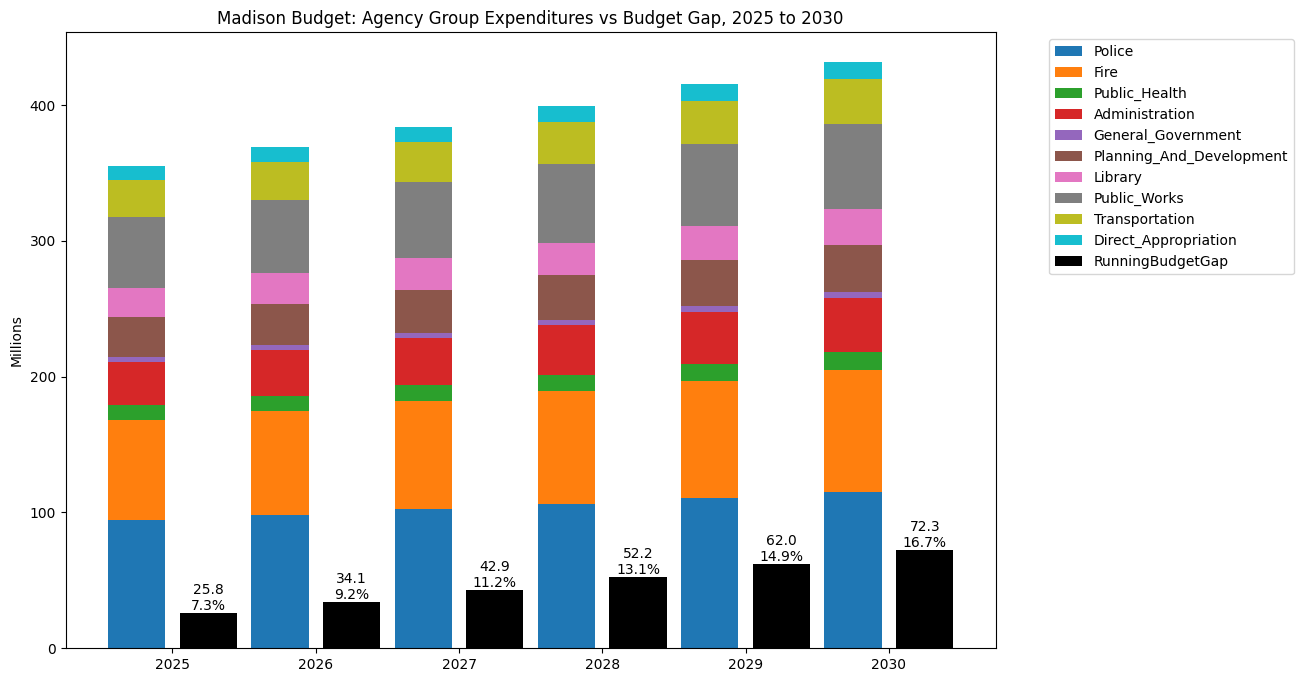

In [22]:
plot_data(sim_results, agency_groups, 2025, 2030)

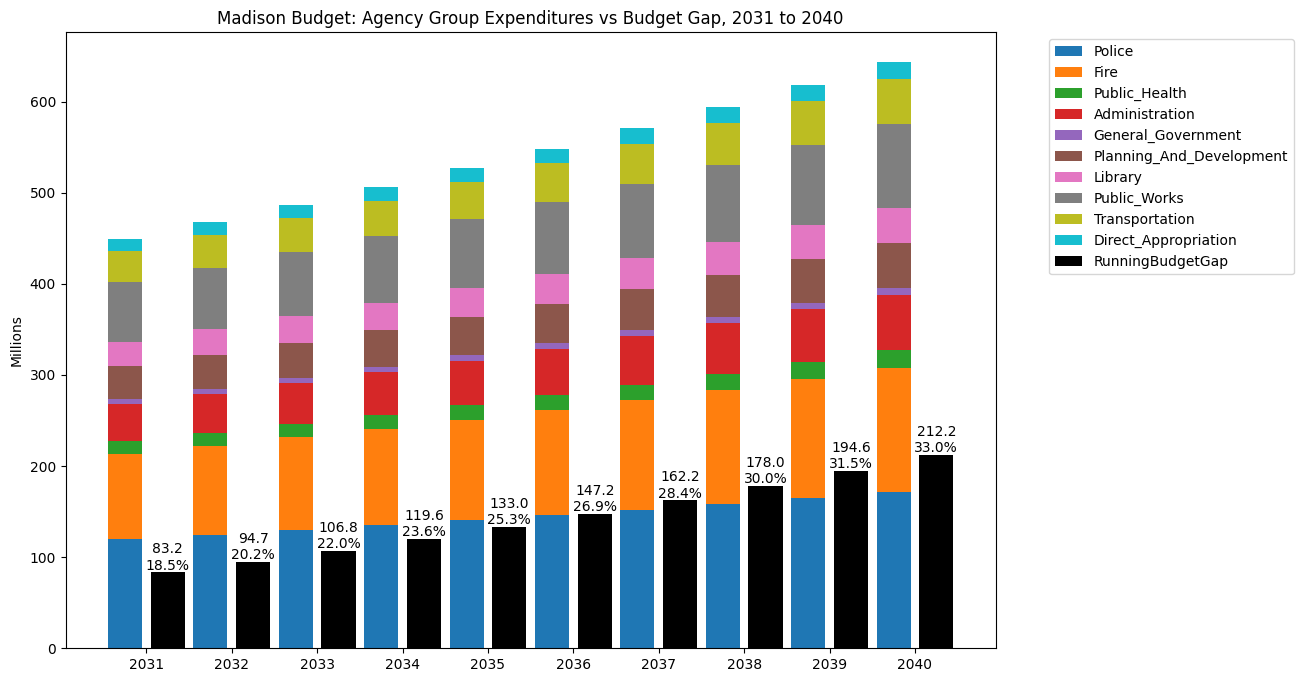

In [23]:
plot_data(sim_results, agency_groups, 2031, 2040)

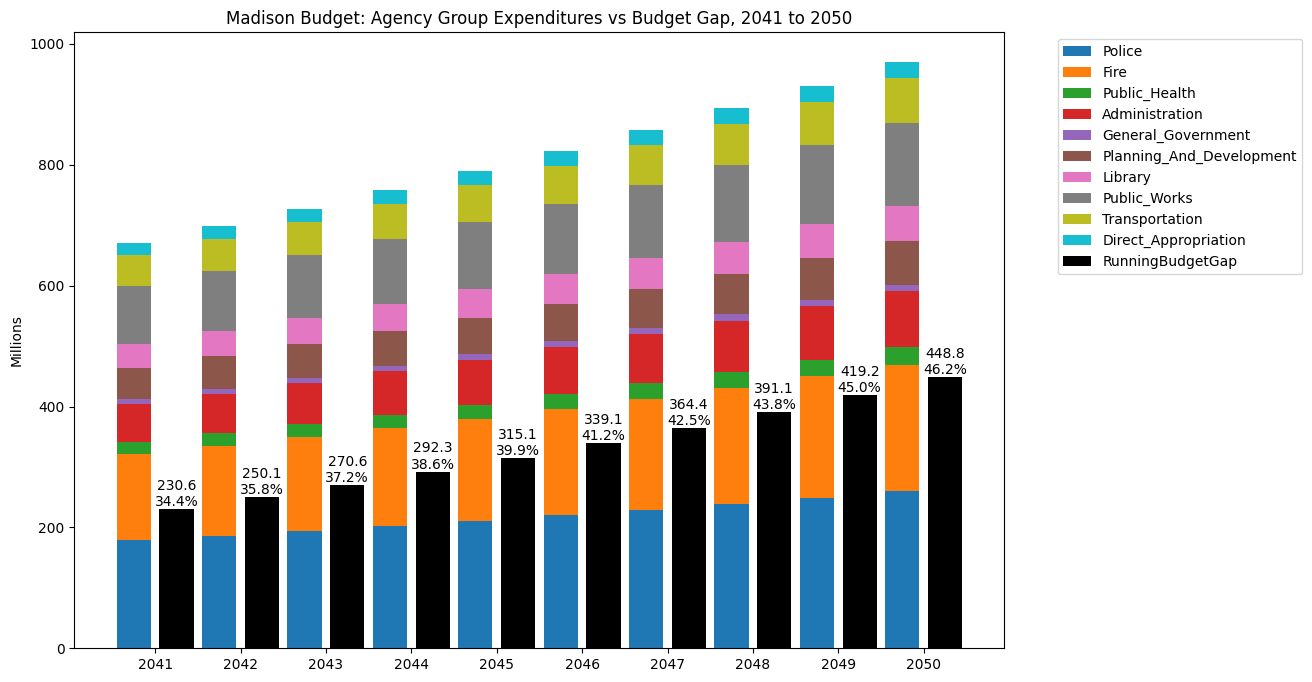

In [24]:
plot_data(sim_results, agency_groups, 2041, 2050)

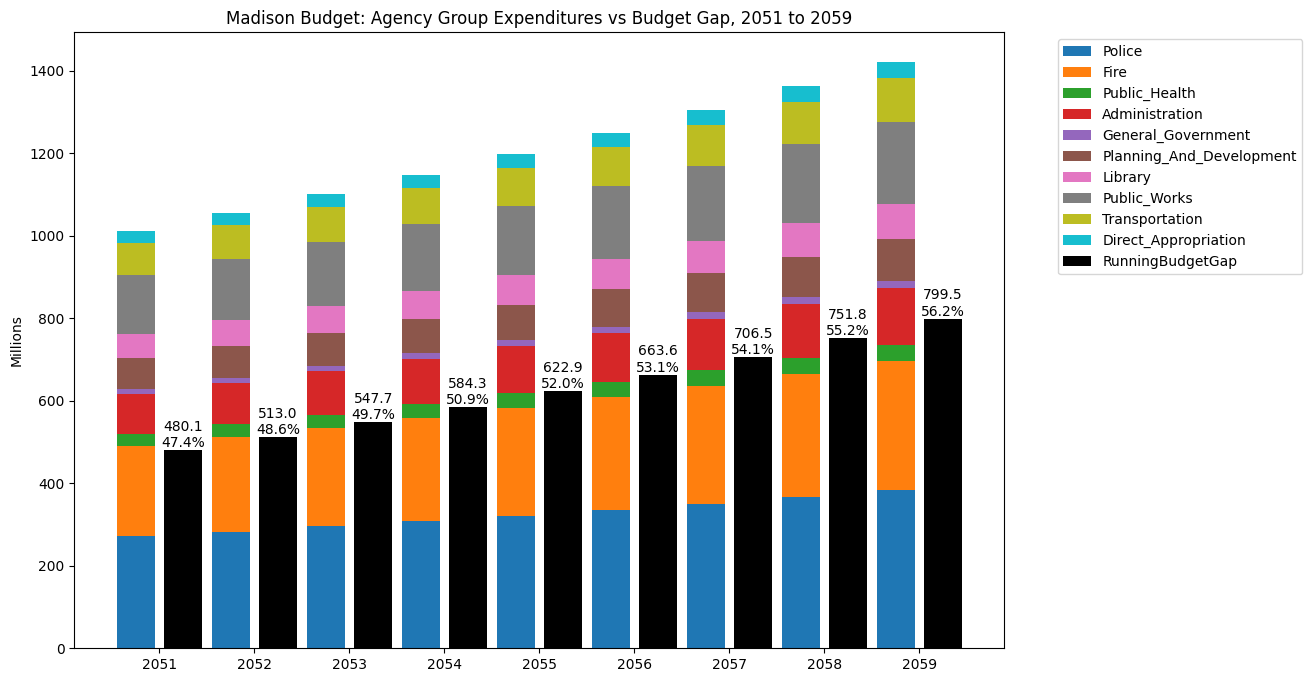

In [25]:
plot_data(sim_results, agency_groups, 2051, 2059)

In [36]:
sim_results.to_csv('simulation_results.csv')

For some additional fun, let's set up a monte-carlo simulation version.
Rather than assuming fixed parameters about how much net new construction, what our interest rates are, how much CPI is, and other economic factors, let's mix it up each year. 
First, we'll write a function (actually, a generator) that creates a new scenario for each year between 2025 and 2059.
This time, however, rather than returning the same values for each year, we randomly throw in recessions, "boom years", and high interest rate years.
If we decide to throw in one of these, we also randomly decide how long it will last and in the case of a recession, how painful it will be.

In a recession, we scale down many of our figures.
For example, we assume that net_new_construction will be less than the normal amount - somewhere between 20% and 50% less than normal.
We also assume the state will not increase our aid as much (we do not consider the possibilty that the state will cut our aid).
In a recession, our interest rate goes down. (Alas, we're not modeling capital costs so we don't see the tax benefits of lower interest rates on bonds)

In a high inflation cycle, we also cut down on the net new construction - in my experience, some builders hold off on projects when inflation is high.
However, we assume that interest rates go up, and that the state (because sales tax revenue goes up) gives us more state aid.

In a boom years cycle, net_new_construction goes up and state aid goes up, but interest rates stay stable.

I should be very honest that this is almost entirely just made up and has basically no basis in any real data.
I hesitated a lot to even include it but I figured why not toss it in for fun.

In [27]:
prob_recession_start = 0.1  # 10% chance of starting a recession each year
avg_recession_duration = 2  # average recession duration in years
recession_impact_range = (0.2, 0.5)  # recession impact is going to cut our rates by something between 50 and 20%

prob_high_inflation_start = 0.1
avg_high_inflation_duration = 2

prob_boom_years_start = 0.1
avg_boom_years_duration = 3


def create_varied_parameters(years):
    years = list(years)
    for year in years:
        if np.random.rand() < prob_recession_start:
            # Start of a recession
            recession_duration = np.random.poisson(avg_recession_duration)
            recession_impact = np.random.uniform(*recession_impact_range)
            
            for _ in range(recession_duration):
                if year >= years[-1]:
                    break
                # Scale down net_new_construction and state_aid during recession
                net_new_construction = default_net_new_construction * (1 - recession_impact)
                state_aid = default_state_increase * (1 - recession_impact)
                interest_rate = default_interest_rate * (1 - recession_impact)
                roomtax = default_roomtax * (1 - recession_impact)
                cpi = np.random.uniform(0.015, 0.022) # what will infation do during a recession? who knows!
                
                revenue_parameters = {
                    'net_new_construction': net_new_construction,
                    'cpi': cpi,
                    'state_increase': state_aid,
                    'reserves': default_reserves,
                    'interest_rate': interest_rate,
                    'roomtax': roomtax,
                }

                expenditure_parameters = {
                    'police_cola': 0.03,
                    'gme_cola': 0.02,
                    'health_ins_rate': 0.065,
                    'new_staff_count': 20,
                    'subsidy_increase': 0.04,
                    'cpi_rate': cpi
                }

                yield revenue_parameters, expenditure_parameters
                year += 1
        elif np.random.rand() < prob_high_inflation_start:
            # Start of high inflation
            high_inflation_duration = np.random.poisson(avg_high_inflation_duration)
            high_inflation_impact = np.random.uniform(0.1,0.5)
            
            for _ in range(high_inflation_duration):
                if year >= years[-1]:
                    break
                # Scale up cpi during high inflation
                cpi = np.random.uniform(0.022, 0.07)
                
                # so in a high inflation world, assume 
                revenue_parameters = {
                    'net_new_construction': default_net_new_construction * (1 - high_inflation_impact),
                    'cpi': cpi,
                    'state_increase': default_state_increase * (1+(high_inflation_impact * 0.75)),
                    'reserves': default_reserves,
                    'interest_rate': default_interest_rate * (1 + (high_inflation_impact*2.0)),
                    'roomtax': default_roomtax * (1+high_inflation_impact),
                }

                expenditure_parameters = {
                    'police_cola': 0.06,
                    'gme_cola': 0.06,
                    'health_ins_rate': 0.065,
                    'new_staff_count': 20,
                    'subsidy_increase': 0.06,
                    'cpi_rate': cpi
                }

                yield revenue_parameters, expenditure_parameters
                year += 1

        elif np.random.rand() < prob_boom_years_start:
            # Start of boom years
            boom_years_duration = np.random.poisson(avg_boom_years_duration)
            boom_years_impact = np.random.uniform(0.1,0.5)

            for _ in range(boom_years_duration):
                if year >= years[-1]:
                    break
                # Scale up net_new_construction and state_aid during boom years
                # but leave our interest rates alone
                #
                # we'll also leave our expneditures alone in a boom year
                net_new_construction = default_net_new_construction * (1 + boom_years_impact)
                state_aid = default_state_increase * (1 + boom_years_impact)
                interest_rate = default_interest_rate 
                roomtax = default_roomtax * (1 + boom_years_impact)
                cpi = np.random.uniform(0.022, 0.03)
                
                revenue_parameters = {
                    'net_new_construction': net_new_construction,
                    'cpi': cpi,
                    'state_increase': state_aid,
                    'reserves': default_reserves,
                    'interest_rate': interest_rate,
                    'roomtax': roomtax,
                }

                expenditure_parameters = {
                    'police_cola': 0.03,
                    'gme_cola': 0.03,
                    'health_ins_rate': 0.065,
                    'new_staff_count': 20,
                    'subsidy_increase': 0.04,
                    'cpi_rate': cpi
                }

                yield revenue_parameters, expenditure_parameters
                year += 1
            # Normal year
            
            revenue_parameters = {
                'net_new_construction': default_net_new_construction,
                'cpi': default_cpi,
                'state_increase': default_state_increase,
                'reserves': default_reserves,
                'interest_rate': default_interest_rate,
                'roomtax': default_roomtax,
            }

            expenditure_parameters = {
                'police_cola': 0.03,
                'gme_cola': 0.03,
                'health_ins_rate': 0.065,
                'new_staff_count': 20,
                'subsidy_increase': 0.04,
                'cpi_rate': 0.022
            }

            yield revenue_parameters, expenditure_parameters

What makes this a 'monte carlo' simulation is that we are going to run the simulation a whole lot of times and see how it turns out, on average. 
So sometimes we'll have a run of good luck - boom year cycle after boom year cycle. 
We'll also sometimes have runs of bad luck - nothing but recessions.

We'll run the simulation 10,000 times, and then lay them all out, best to worst.
We'll report back what was the middle results - where our luck wasn't the terrible but wasn't amazing, which is what we hope happens.
We'll also report on the 5th and 95th percentile results, which are bascially "We'd have to get really really luck to get there" and "we'd have to have things go very, very wrong to get these."

Also fair warning, my implementation is terrible and this is slow as hell, like laughably slow. But I'm only every going to run it once in my life so I don't care.

The trick here is we use a different generator function for the parameters. 

In [28]:
def monte_carlo_simulation(num_trials=1000):
    # Run the simulation_trial function num_trials times
    # Store the resulting dataframes in a list
    dfs = [simulation_trial(create_varied_parameters) for _ in tqdm(range(num_trials))]
    return dfs

In [29]:
def create_reporting_df(dfs):
    # Initialize an empty dataframe for the report
    report_df = pd.DataFrame()

    # For each year, calculate the mean, median, 5th and 95th percentile for RunningBudgetGap and IncrementalGap
    for year in range(2025, 2060):
        year_dfs = [df.loc[year] for df in dfs if year in df.index]
        running_budget_gap_values = [df['RunningBudgetGap'] for df in year_dfs]
        incremental_gap_values = [df['IncrementalGap'] for df in year_dfs]

        report_df.loc[year, 'RunningBudgetGapMean'] = np.mean(running_budget_gap_values)
        report_df.loc[year, 'RunningBudgetGapMedian'] = np.median(running_budget_gap_values)
        report_df.loc[year, 'RunningBudgetGap5thPercentile'] = np.percentile(running_budget_gap_values, 5)
        report_df.loc[year, 'RunningBudgetGap95thPercentile'] = np.percentile(running_budget_gap_values, 95)

        report_df.loc[year, 'IncrementalGapMean'] = np.mean(incremental_gap_values)
        report_df.loc[year, 'IncrementalGapMedian'] = np.median(incremental_gap_values)
        report_df.loc[year, 'IncrementalGap5thPercentile'] = np.percentile(incremental_gap_values, 5)
        report_df.loc[year, 'IncrementalGap95thPercentile'] = np.percentile(incremental_gap_values, 95)

    return report_df

In [30]:
# Run the Monte Carlo simulation.
# this is kind of silly for this blogpost because recessions don't happen that often and because we only compute on year by year and the average duration is only 2 years
# we don't see a lot of variation in the results. It'd be more fun if we the city had finances that we more dependent on economic activity but 
# that's part of the complaint about the city's finances - it doesn't benefit from the updsides of economic activity like it would if it had a sales tax or income tax
# but on the plus side it doesn't have o deal with what happens when sales tax revenue tanks during a recession
dfs = monte_carlo_simulation(10000)

# Create the report
report_df = create_reporting_df(dfs)


100%|██████████| 10000/10000 [34:12<00:00,  4.87it/s]


In [31]:
report_df

,RunningBudgetGapMean,RunningBudgetGapMedian,RunningBudgetGap5thPercentile,RunningBudgetGap95thPercentile,IncrementalGapMean,IncrementalGapMedian,IncrementalGap5thPercentile,IncrementalGap95thPercentile
2025,27429182.85,27246653.10,23798784.17,31946352.55,9529182.85,9346653.10,5898784.17,14046352.55
2026,37777654.72,34977319.55,30163530.78,49169207.06,10348906.43,7902772.14,5995968.85,17889773.89
2027,48523056.85,43503844.92,37308499.81,67772762.41,10745895.64,8492650.45,6311951.10,19220563.95
2028,59771554.39,52959853.97,45119433.40,87843543.69,11252020.24,9115927.69,6689035.94,20551068.22
2029,71691963.30,64050158.29,53456429.31,109390959.53,11920659.45,9625090.32,7178222.60,21917029.98
2030,84286531.75,77145625.47,62550454.77,129867095.92,12629063.42,10167810.01,7657646.60,23215419.73
2031,97588810.04,91188671.22,72089118.61,147810583.79,13329511.32,10728256.92,8150955.76,24186762.42
2032,111561836.63,106162491.37,82197279.68,163954833.08,14031355.97,11346314.01,8713289.41,25483885.59
2033,126419458.92,120706055.62,92930158.43,186030868.36,14876268.38,12123007.09,9281010.22,26679060.10
2034,142038583.99,135473613.91,104026650.65,205760954.63,15723312.69,12877752.70,9847352.68,28016564.20


Text(0.5, 1.0, 'Madison Budget Gap 2025-2059 (10,000 trials)')

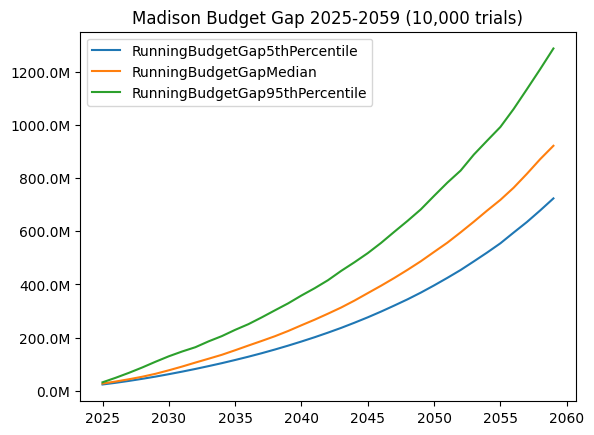

In [32]:
import matplotlib.ticker as mtick

ax = report_df[['RunningBudgetGap5thPercentile', 'RunningBudgetGapMedian', 'RunningBudgetGap95thPercentile']].plot()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{}M'.format(x*1e-6)))
ax.set_title('Madison Budget Gap 2025-2059 (10,000 trials)')

In [33]:
report_df.to_csv('monte_carlo_results.csv')

In [61]:
def plot_healthcare_data(sim_results, start_year, stop_year):
    years = range(start_year, stop_year+1)
    width = 0.35  # the width of the bars

    # First chart
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar([year - width/2 for year in years], sim_results.loc[years, 'Expenditures']/1e6, width, label='Expenditures')  # Divide by 1e6 to display in millions
    bars = ax.bar([year + width/2 for year in years], sim_results.loc[years, 'HealthInsurance']/1e6, width, label='HealthInsurance')  # Divide by 1e6 to display in millions
    ax.set_title('Health Insurance vs Overall Budget')
    ax.set_ylabel('Millions')  # Label the Y axis
    ax.legend()

    # Add labels over the HealthInsurance bars
    for i, bar in enumerate(bars):
        temp = sim_results.loc[years[i], 'HealthInsuranceOverallPortion'] * 100.0
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{temp:.1f}%', ha='center', va='bottom')

    # Second chart
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar([year - width/2 for year in years], sim_results.loc[years, 'CostToContinue']/1e6, width, label='CostToContinue', color='purple')  # Divide by 1e6 to display in millions
    bars = ax.bar([year + width/2 for year in years], sim_results.loc[years, 'HealthInsuranceDelta']/1e6, width, label='HealthInsuranceDelta', color='yellow')  # Divide by 1e6 to display in millions
    ax.set_title('Cost to Continue vs Yearly Health Insurance Increase')
    ax.set_ylabel('Millions')  # Label the Y axis
    ax.legend()

    # Add labels over the HealthInsuranceDelta bars
    for i, bar in enumerate(bars):
        temp = sim_results.loc[years[i], 'HealthInsuranceCostToContinuePortion'] * 100.0
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{temp:.1f}%', ha='center', va='bottom')

    plt.show()

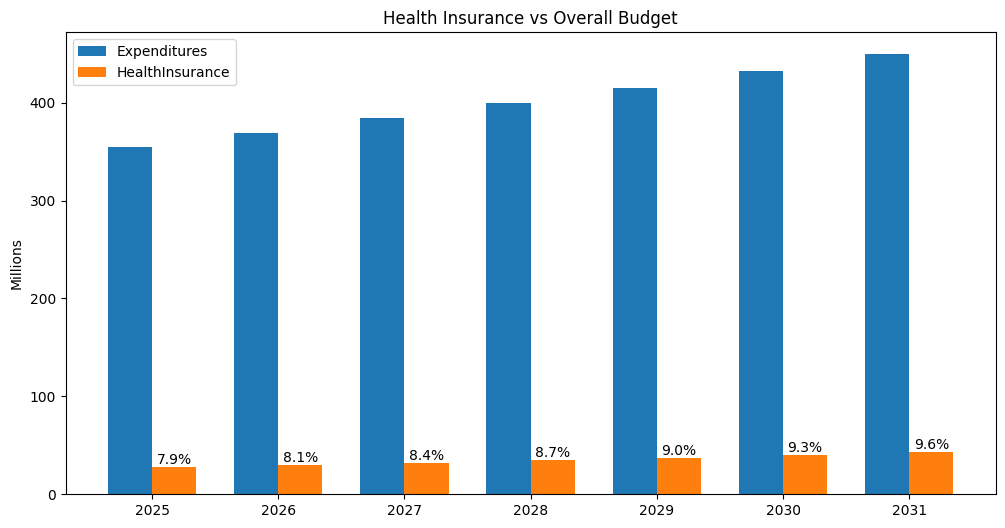

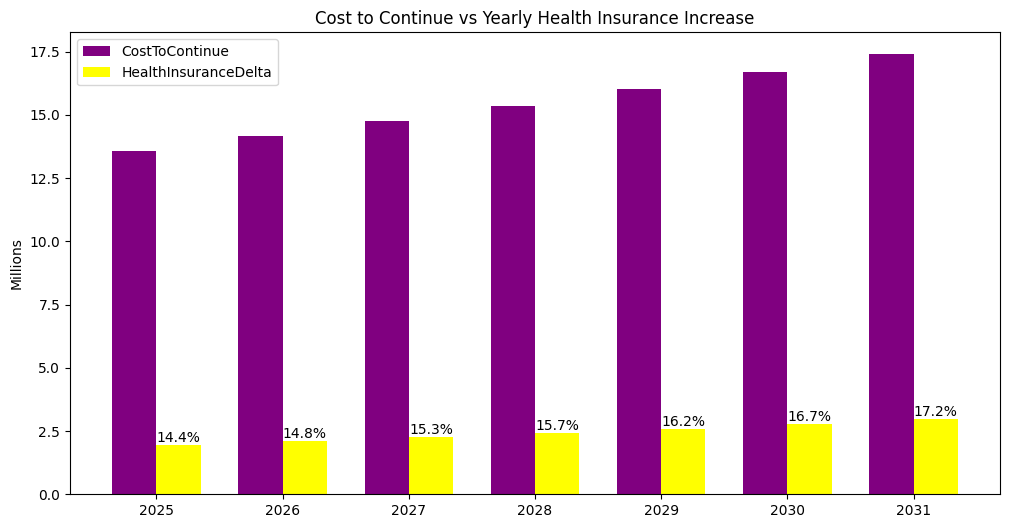

In [62]:
plot_healthcare_data(sim_results, 2025, 2031)

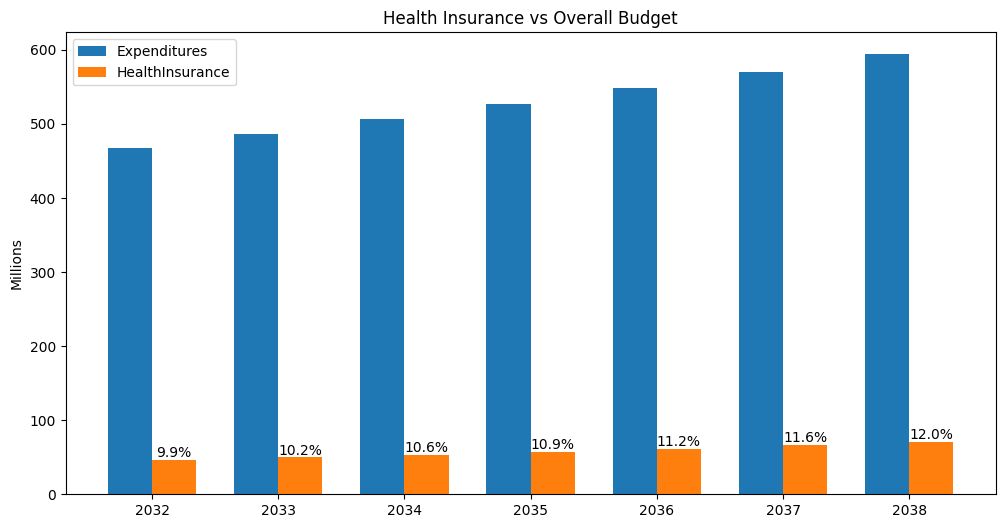

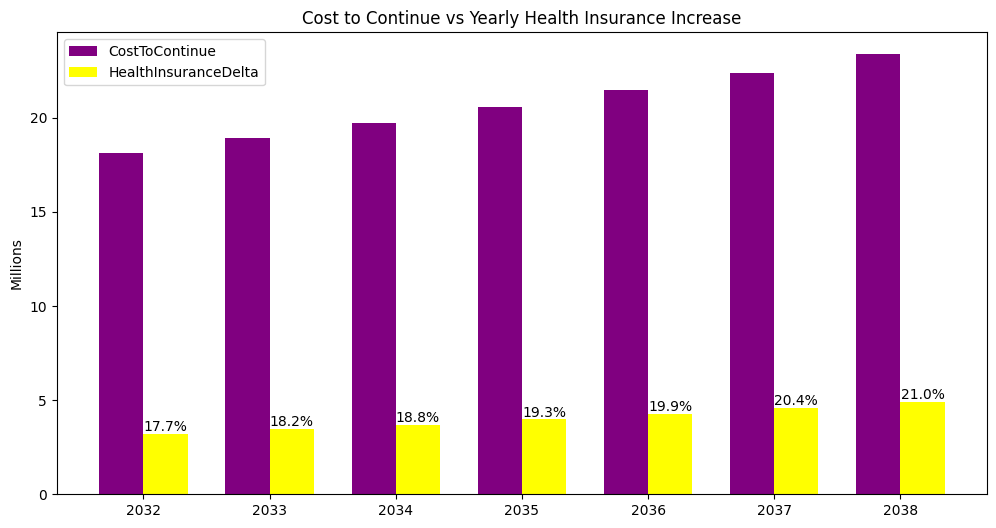

In [63]:
plot_healthcare_data(sim_results, 2032, 2038)

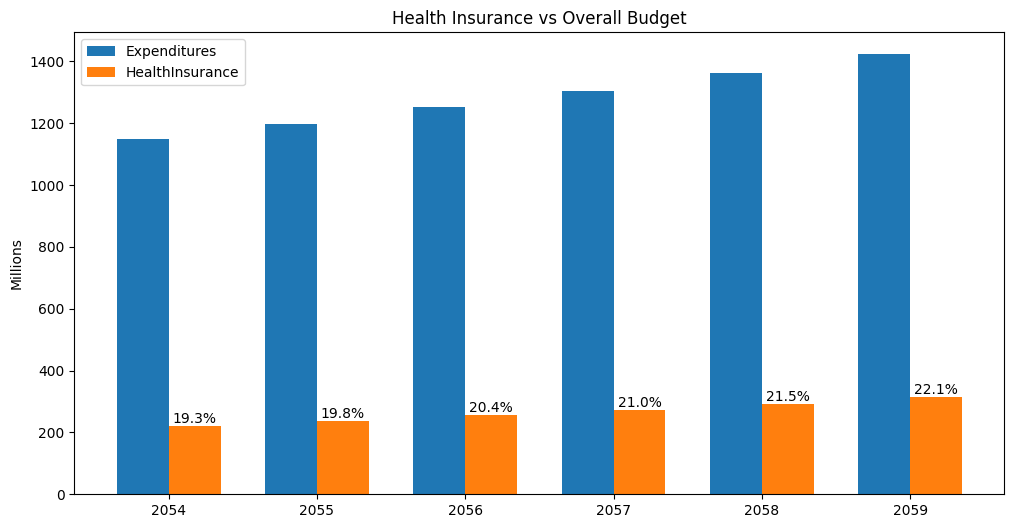

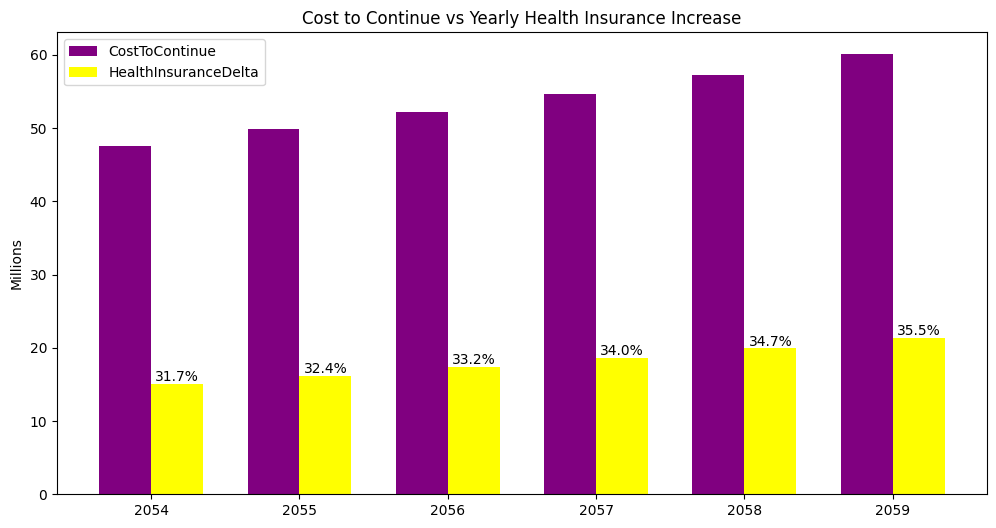

In [64]:
plot_healthcare_data(sim_results, 2054, 2059)